# Projet de base

In [1]:
import numpy as np
import math
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib import pyplot as plt
import copy
import time

In [2]:
class Node:
    
    def __init__(self,idx, parent, children, lb, visited):
        self.idx = idx
        self.parent = parent
        self.children = children
        self.lb = lb
        self.visited = visited
        
    def __str__(self):
        return ("Parent : " +str(self.parent)+
                "\n Children : "+str(self.children) + 
                "\n lb : "+str(self.lb)+ 
                "\n visited : "+str(self.visited))

In [3]:
def arborescence(node,Tree):
    branch = []
    while node.parent != None:
        branch.append(node)
        node = Tree[node.parent]
    branch.append(node)
    
    return branch

In [4]:
def computeCost(p,d,w,order):
    t=0
    cost=0
    for idx in order:
        t += p[idx]
        cost += max(0,(t-d[idx])*w[idx])
    return cost

In [5]:
p = [12,8,15,9]
d = [16,26,25,27]
w = [4,5,3,5]

In [6]:
def getPrimal_0(p,d,w):
    sortedTasks = np.argsort(d)
    cost = computeCost(p,d,w,sortedTasks)
    return(cost,sortedTasks)


def getPrimal_1(p,d,w):
    sortedTasks = (np.argsort((np.array(d)-np.array(p))*np.array(w)))[::-1]
    cost = computeCost(p,d,w,sortedTasks)
    return(cost,sortedTasks)


def getPrimal_2(p,d,w):
    tasksLeft = [int(i) for i in range(len(p))]
    order = []
    while len(tasksLeft)!= 0:
        time = np.sum(np.array(p)[tasksLeft])
        penalities = (time-np.array(d)[tasksLeft])*np.array(w)[tasksLeft]
        sortedTasks = np.argsort(penalities)
        order.append(tasksLeft[sortedTasks[0]])
        tasksLeft.pop(sortedTasks[0])
    order.reverse()
    cost = computeCost(p,d,w,order)
    return(cost,order)

In [7]:
def getDual_0(p,d,w,visited):
    dual=0
    time=0
    notVisited=list(range(len(p)))
    for i in visited:
        retard=((p[i]+time)-d[i])
        dual+=retard*w[i]*(retard>0)
        time+=p[i]
        notVisited.remove(i)
        
    for j in notVisited:
        retard=(p[j]+time)-d[j]
        dual+=retard*w[j]*(retard>0)
    return dual

def getDual_1(p,d,w,visited):
    dual = 0
    time = 0
    notVisited = list(range(len(p)))
    for i in visited:
        retard = ((p[i]+time)-d[i])
        dual += retard*w[i]*(retard>0)
        time += p[i]
        notVisited.remove(i)
    return dual

def getDual_2(p,d,w,visited):
    dual = 0
    time = np.sum(p)
    for i in visited:
        retard = (time-d[i])
        dual += retard*w[i]*(retard>0)
        time -= p[i] 
    return dual

def getDual_3(p,d,w,visited):
    dual = 0
    time = np.sum(p)
    notVisited=list(range(len(p)))
    for i in visited:
        retard = (time-d[i])
        dual += retard*w[i]*(retard>0)
        time -= p[i] 
        notVisited.remove(i)
    for j in notVisited:
        if time - p[j] < d[j]:
            retard = time-d[j]
            dual+=retard*w[j]*(retard>0)
    return dual

In [8]:
def exploration_0(Queue,Tree,UB):
    return(Queue[0])

def exploration_1(Queue,Tree,UB):
    return(Queue[-1])

def exploration_2(Queue,Tree,UB):
    bestNode = Queue[-1]
    bestLB = -math.inf
    for idx in Queue:
        if Tree[idx].lb > bestLB and Tree[idx].lb < UB:
            bestLB = Tree[idx].lb
            bestNode = idx
    return(bestNode)

In [9]:
def branch_and_bound(p,d,w,byLast,getPrimal,getDual,exploration):
    
    Tasks = list(range(len(p)))
    Tree = [] # list of all nodes created (a list of Node objects)
    Queue = [] # list of nodes to process (a list of integers with the index of nodes to process in the Tree)
    UB = 10000000 # Upper Bound of the problem
    LB = 0 # best Lower Bound of the problem 
    
    UB,currentOrder = getPrimal(p,d,w) #We start by computing the first primal/upper bound.

    bestNode = Node(-1,-1, [], 0 ,[]) #default best node
    
    root = Node(0,None, [], 0, []) # define the root node of the tree
    Tree.append(root) # start the tree with the root node
    Queue.append(0) # start the list of nodes to process with the root node
    
    #continue processing nodes until the queue is empty
    
    nbIterations = 0
    
    while len(Queue)!=0 :
        
        # process the nodes in the queue according to the chosen exploration method
        
        currentIndex = exploration(Queue,Tree,UB)
        currentNode = Tree[currentIndex]
        nbIterations += 1
        
        if currentNode.lb < UB:
            
            # If the processed node corresponds to a "full-schedule" we check whether this solution is an improvement or not
            # If so, we update the problem Upper Bound / best order / best node
            
            if len(currentNode.visited) == len(p):
                order = copy.copy(currentNode.visited)
                if byLast:
                    order.reverse()
                solutionCost = computeCost(p,d,w,order)
                if solutionCost <= UB:
                    UB = solutionCost
                    currentOrder = order
                    bestNode = currentNode
            else:
                
                #for each task not processed yet we create a new node
                for nextTask in (set(Tasks)-set(currentNode.visited)):
                    nextVisited = copy.copy(currentNode.visited)
                    nextVisited.append(nextTask)
                    nextLb = getDual(p,d,w, nextVisited)

                    newNode = Node(len(Tree),currentIndex, [], nextLb,nextVisited)
                    Tree.append(newNode)
                    Queue.append(len(Tree)-1)
                    currentNode.children.append(len(Tree)-1)
            
        # When the processing of the node is completed remove the node from the queue     
        Queue.remove(currentIndex)

    # return the  solution
    
    if (UB-bestNode.lb)<=0.0001:
        branch = arborescence(bestNode,Tree)
    
    # If the best node is not a leaf, the bestNode variable is still the default one default
    else:
        bestLB = -math.inf
        for node in Tree:
            if node.lb > bestLB and node.lb <=UB:
                bestLB = node.lb
                bestNode=node
        branch = arborescence(bestNode,Tree)

    return UB, currentOrder, nbIterations, branch, Tree

# Extension

__>__ Nous allons maintenant considérer une extension de notre problème dans lequel l'atelier dispose de plusieurs machines : 
Nous ne changeons pas la structure du code, nous nous appuierons toujours sur la classe Node, les fonctions _getPrimal_, _getDual_, _exploration_ et sur la fonction _Branch and Bound_.


Le changement majeur est le changement de format de l'attribut _visited_ de chacun de nos noeuds. En effet, auparavant, cet attribut était une liste stockant les tâches déja réalisées (visted = [0,4,7] <=> les tâches 0,4,7 sont éffectuées, que ce soit en partant de la fin ou du début. 
Donéranavant, l'attribut _visited_ sera une liste de listes, où la liste à l'index 0 correspondra aux tâches réalisées dans l'odre par la machine 0, etc... 


visited : [0,2,3] -> [[0,2],[3]]

In [10]:
class Node:
    
    def __init__(self,idx, parent, children, lb, visited):
        self.idx = idx
        self.parent = parent
        self.children = children
        self.lb = lb
        self.visited = visited
        
    def __str__(self):
        return ("Parent : " +str(self.parent)+
                "\n Children : "+str(self.children) + 
                "\n lb : "+str(self.lb)+ 
                "\n visited : "+str(self.visited))

__>__ Une des premières fonctions à redéfinir pour ce nouveau problème était la fonction _computeCost_ qui nous permettra de calculer le coût d'une solution proposée. Le fonctionnement est le même qu'aparavant, on prend juste soin d'itérer sur chaque machine en pensant à réinitialiser le temps à 0.

In [11]:
def computeCost(p,d,w,orders,n):
    cost=0
    for order in orders:
        t=0
        for idx in order:
            t += p[idx]
            cost += max(0,(t-d[idx])*w[idx])
    return cost

def getPrimal_2(p,d,w,n):
    tasksLeft = [int(i) for i in range(len(p))]
    orders = []
    while len(tasksLeft)!= 0:
        time = np.sum(np.array(p)[tasksLeft])
        penalities = (time-np.array(d)[tasksLeft])*np.array(w)[tasksLeft]
        sortedTasks = np.argsort(penalities)
        order.append(tasksLeft[sortedTasks[0]])
        tasksLeft.pop(sortedTasks[0])
    order.reverse()
    cost = computeCost(p,d,w,orders,n)
    return(cost,order)

def getPrimal_2(p,d,w,n):
    tasksLeft = [int(i) for i in range(len(p))]
    orders = [[] for _ in range(n)]
    time = [np.sum(np.array(p)[tasksLeft])]*n
    
    while len(tasksLeft)!= 0:
        bestPenalty = (1e99,0,0)
        for k in range(n):
            penalties = (time[k]-np.array(d)[tasksLeft])*np.array(w)[tasksLeft]
            sortedTasks = np.argsort(penalties)
            if sortedTasks[0]<bestPenalty[0]:
                bestPenalty = (sortedTasks[0], k, tasksLeft[sortedTasks[0]]) #Penalty / machine / task
        
        orders[bestPenalty[1]].append(bestPenalty[2]) #orders[machine].append(task)
        time[bestPenalty[1]] -= p[bestPenalty[2]]
        tasksLeft.pop(sortedTasks[0])
    for order in orders:
        order.reverse()
    order.reverse()
    cost = computeCost(p,d,w,orders,n)
    return(cost,order)

__>__ Suite à ça, nous définissons une nouvelle fonction _getPrimal_. La manière la plus simple de calculer une borne primale que nous ayons trouvé est de ranger les tâches par odre croissant de date limite et de les affecter une par une à chacune des machines. À défaut d'être optimale voir même performante, cette méthode nous a néanmoins permis de vérifier le bon fonctionnement de notre algorithme.

In [12]:
def getPrimal(p,d,w,n):
    sortedTasks = np.argsort(d)
    orders = [[] for _ in range(n)]
    for i in range(len(sortedTasks)):
        orders[i%n].append(sortedTasks[i])
    cost = computeCost(p,d,w,orders,n)
    return(cost,orders)

def getDual(p,d,w,visited,n):
    dual = 0
    time = [np.sum(p)]*n #-> [90,90,90] pour n = 3 par exemple
    for k in range(n):
        machine = visited[k]
        for i in machine:
            retard = (time[k]-d[i])
            dual += retard*w[i]*(retard>0)
            time[k] -= p[i] 
    return dual

__>__ Nous définissons ensuite notre fonction _getDual_ qui sera exécutée à chaque création d'un nouveau noeud de l'arbre pour en calculer sa borne primale. Si on a fixé l'ordre de $k$ pièces on calcule les pénalités de retard de ces $k$ pièces pour chaque machine et on ajoute les pénalités des autres pièces en supposant qu'elles sont en $(k_i+1)$ème position, et en prenant la pénalité de retard minimum parmis toutes les machines.  

In [13]:
def getDual(p,d,w,visited,n):
    dual = 0
    notVisited=list(range(len(p)))
    time = [0]*n 
    for k in range(n):
        machine = visited[k]
        for i in machine:
            retard = (time[k] + p[i] -d[i])
            dual += retard*w[i]*(retard>0)
            time[k] += p[i]
            notVisited.remove(i)
    for j in notVisited:
        retard=min([(p[j]+time[k])-d[j] for k in range(n)])
        dual+=retard*w[j]*(retard>0)
    return dual

In [14]:
def getDual_2(p,d,w,visited,n):
    dual = 0
    notVisited=list(range(len(p)))
    time = [0]*n 
    for k in range(n):
        machine = visited[k]
        for i in machine:
            retard = (time[k] + p[i] -d[i])
            dual += retard*w[i]*(retard>0)
            time[k] += p[i]
            notVisited.remove(i)
    return dual

On conserve les mêmes méthodes d'exploration que précédemment.

In [15]:
def exploration_0(Queue,Tree,UB):
    return(Queue[0])

def exploration_1(Queue,Tree,UB):
    return(Queue[-1])

Finalement, nous modifions notre algorithme _Branch and Bound_ pour correspondre à ce problème. Les éléments que nous avons changé sont : 

__Entrée :__ 

* __n :__ Ajout d'un nouveau paramètre pour indiquer le nombre de machines à disposition.

__Exécution :__

* __getPrimal :__ Utilisation de notre nouvelle fonction getPrimal pour n machines

* __root node :__ Changement de format de root.visited.

* __Vérification tâches éffectuées :__ On ne peut plus simplement regarder la longueur/composition de noeud.visited mais on doit additionner la longueur de chaque liste/ itérer sur les listes en plusieurs lignes.

* __computeCost :__ Utilisation de notre nouvelle fonction computeCost pour n machines

* __getDual :__ Utilisation de notre nouvelle fonction getDual pour n machines

* __nextVisited :__ Une utilisation d'un simple copy.copy() n'était plus suffisante pour une liste de listes. L'ajout d'un noeud à nextVisited l'ajoutait aussi à currentNode. Nous avons domc remplacé par un deepcopy()

* __Création nouveau noeud :__ On crée un nouveau noeud par tâche non visitée pour chaque machine.

In [16]:
def branch_and_bound(p,d,w,byLast,getPrimal,getDual,exploration,n):
    
    Tasks = list(range(len(p)))
    Tree = [] 
    Queue = [] 
    UB = 10000000 
    LB = 0 
    
    UB,currentOrder = getPrimal(p,d,w,n) #New primal bound computation
    #print("Primal Bound : {} | Order : {}".format(UB,currentOrder))
    bestNode = Node(-1,-1, [], 0 ,[])
    
    #NEW
    #We changed the root node visited attribute to match the problem
    root = Node(0,None, [], 0, [[] for _ in range(n)]) 
    Tree.append(root) 
    Queue.append(0) 
    
    nbIterations = 0
    
    while len(Queue)!=0 :
        
        currentIndex = exploration(Queue,Tree,UB)
        currentNode = Tree[currentIndex]
        nbIterations += 1
        
        if currentNode.lb < UB:
            
            #NEW
            #We needed to change the conition to know whether we visited all the tasks or not
            if sum([len(visited) for visited in currentNode.visited]) >= len(p):
                orders = copy.copy(currentNode.visited)
                if byLast:
                    for order in orders:
                        order.reverse()
                #NEW
                #ComputeCost changed
                solutionCost = computeCost(p,d,w,orders,n)
                if solutionCost <= UB:
                    UB = solutionCost
                    currentOrder = orders
                    bestNode = currentNode
            else:
                
                #NEW
                #Listing all the visited tasks is now too difficult to be nicely written in a single line
                allVisitedTasks = []
                visited_copy = copy.copy(currentNode.visited)
                for machine in visited_copy:
                    for task in machine:
                        allVisitedTasks.append(task)
                
                #print(currentNode.visited)
                
                #NEW
                #Iterate over all the machines
                for k in range(n):
                    for nextTask in (set(Tasks)-set(allVisitedTasks)):
                        #NEW
                        #visited is now a list of lists so we need to deepcopy it
                        nextVisited = copy.deepcopy(currentNode.visited)
                        #machine by machine
                        nextVisited[k].append(nextTask)
                        nextLb = getDual(p,d,w, nextVisited,n) #New dual bound computation

                        newNode = Node(len(Tree),currentIndex, [], nextLb,nextVisited)
                        Tree.append(newNode)
                        Queue.append(len(Tree)-1)
                        currentNode.children.append(len(Tree)-1)
               
        Queue.remove(currentIndex)

    
    if (UB-bestNode.lb)<=0.0001:
        branch = arborescence(bestNode,Tree)
    
    else:
        bestLB = -math.inf
        for node in Tree:
            if node.lb > bestLB and node.lb <=UB:
                bestLB = node.lb
                bestNode=node
        branch = arborescence(bestNode,Tree)

    return UB, currentOrder, nbIterations, branch, Tree

# Test de nos fonctions : 

Dans un premier temps nous définissons un exemple assez simple qui nous permettra de vérifier le bon fonctionnement de notre algortihme. Nous choisissons de n'utiliser que deux machines et de ne donner que 6 pièces à produire. Toutes les pièces seront usinables en temps sauf une, la pièce 6, qui engendrera un pénalité. 

* __Temps de produiction :__ p = [2,3,4,2,3,6]


* __Dates limite :__ d = [2,5,9,2,5,7]


* __Poids de pénalité :__ w = [1,1,1,1,1,1]


Si notre algorithme fonctionne correctement, il devrait renvoyer une solution de 4 illustrée sur le schéma ci-dessous. 

<img src="img/2machinestoyexample.png"
     style="" />

In [17]:
p = [2,3,4,2,3,6]
d = [2,5,9,2,5,7]
w = [1,1,1,1,1,1]

orders = [[0,1,2],[3,4,5]]
computeCost(p,d,w,orders,2)

4

In [18]:
sol, order, _ ,_ ,_= branch_and_bound(p,d,w,True,getPrimal,getDual,exploration_1,2)
print("Solution :", sol)
print("Ordre : ", order)

Solution : 4
Ordre :  [[0, 1, 5], [3, 4, 2]]


__Conclusion :__ Notre algorithme nous a renvoyé la bonne réponse sur ce problème particulièrement simple. Nous allons maintenant le tester sur différentes intances aléatoires de notre problème.

__Instances aléatoires :__ Comme précédemment nous allons définir une fonction pour générer des instances aléatoires de notre problème. Le code est globalement le même mais nous divisons la date limite maximum par le nombre de machines.

In [19]:
def genMultiInstances(n,alpha,n_machines):
    p=np.random.randint(1,15,n)
    d=np.random.randint(3,int(alpha*n*15/n_machines),n)
    w=np.random.randint(1,5,n)
    return(p,d,w)

In [20]:
for _ in range(3):
    print("______________________")
    p,d,w = genMultiInstances(6,.4,2)
    print("p : ", p)
    print("d : ", d)
    print("w : ", w)
    sol, order, nbIt ,_ ,_= branch_and_bound(p,d,w,True,getPrimal,getDual,exploration_1,2)
    print("Solution : {} | Ordre : {} | nbit : {}".format(sol,order,nbIt))
    sol, order, nbIt ,_ ,_= branch_and_bound(p,d,w,True,getPrimal,getDual_2,exploration_1,2)
    print("Solution : {} | Ordre : {} | nbit : {}".format(sol,order,nbIt))

______________________
p :  [12  6  4  1  1  7]
d :  [14 15 17 17  4  3]
w :  [3 1 1 1 2 4]
Solution : 37 | Ordre : [[5, 0, 2], [4, 1, 3]] | nbit : 23025
Solution : 37 | Ordre : [[5, 0, 2], [4, 1, 3]] | nbit : 43365
______________________
p :  [ 3  9  4  3  6 11]
d :  [13  4  9  7  6 15]
w :  [1 4 4 1 2 4]
Solution : 55 | Ordre : [[1, 3, 0], [4, 2, 5]] | nbit : 9009
Solution : 55 | Ordre : [[1, 3, 0], [4, 2, 5]] | nbit : 38841
______________________
p :  [ 7  5 10  3 12  7]
d :  [ 8 12  5 14  4  8]
w :  [2 1 2 4 1 3]
Solution : 66 | Ordre : [[0, 1, 4], [2, 3, 5]] | nbit : 22795
Solution : 66 | Ordre : [[0, 1, 4], [2, 3, 5]] | nbit : 50591


__Résultats :__ On remarque que comme on pouvait s'y attendre, la méthode $getDual\_2$ est moins performante que $getDual$.

Text(0.5, 1.0, "Temps d'exécution en fonction de la taille du problème - alpha:0.4 | N=1 | n_machines=2/3")

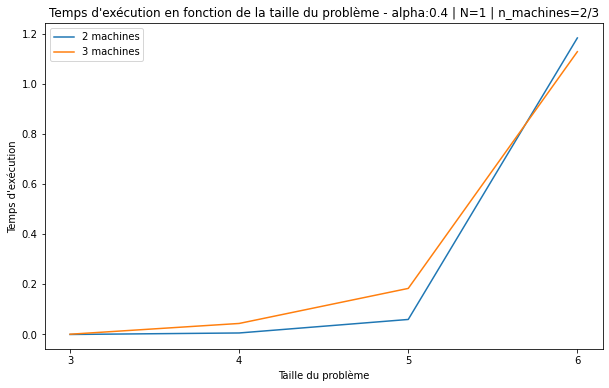

In [21]:
N = 1 #Nombre d'échantillons
n = 7 #Taille maximum du problème
alpha = 0.4

resultats_BB = [[] for i in range(3,n)]
resultats_BB_2 = [[] for i in range(3,n)]

for _ in range(N):
    for i in range(3,n):
        p,d,w = genMultiInstances(i,alpha,2)
        
        #n_machines = 2 
        start = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, True, getPrimal, getDual,exploration_1, 2)
        end = time.time()
        resultats_BB[i-3].append(end-start)
        
        p,d,w = genMultiInstances(i,alpha,3)
        #n_machines = 3
        start = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, True, getPrimal, getDual,exploration_1, 3)
        end = time.time()
        resultats_BB_2[i-3].append(end-start)

resultats_BB_2 = [np.mean(res) for res in resultats_BB_2]
resultats_BB_2 = np.array(resultats_BB_2)

resultats_BB = [np.mean(res) for res in resultats_BB]
resultats_BB = np.array(resultats_BB)

plt.figure(figsize=(10,6))
X = list(range(3,n))
plt.plot(X,resultats_BB, label="2 machines")
plt.plot(X,resultats_BB_2, label="3 machines")
plt.xlabel("Taille du problème")
plt.xticks(X)
plt.legend()
plt.ylabel("Temps d'exécution")
plt.title("Temps d'exécution en fonction de la taille du problème - alpha:{} | N={} | n_machines={}".format(alpha,N,"2/3"))

Text(0.5, 1.0, "Temps d'exécution en fonction de la taille du problème - alpha:0.4 | N=1 | n_machines=2/3")

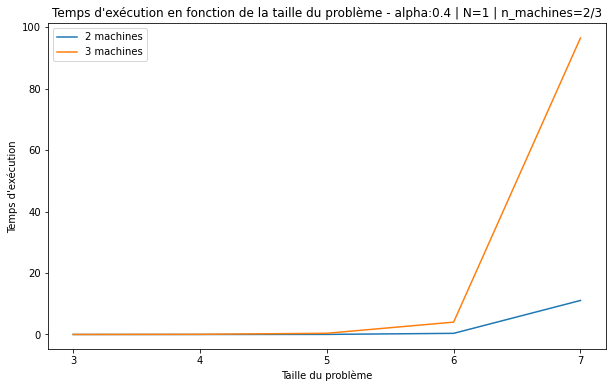

In [22]:
N = 1 #Nombre d'échantillons
n = 8 #Taille maximum du problème
alpha = 0.4

resultats_BB = [[] for i in range(3,n)]
resultats_BB_2 = [[] for i in range(3,n)]

for _ in range(N):
    for i in range(3,n):
        p,d,w = genMultiInstances(i,alpha,2)
        
        #n_machines = 2 
        start = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, True, getPrimal, getDual,exploration_1, 2)
        end = time.time()
        resultats_BB[i-3].append(end-start)
        
        p,d,w = genMultiInstances(i,alpha,3)
        #n_machines = 3
        start = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, True, getPrimal, getDual,exploration_1, 3)
        end = time.time()
        resultats_BB_2[i-3].append(end-start)

resultats_BB_2 = [np.mean(res) for res in resultats_BB_2]
resultats_BB_2 = np.array(resultats_BB_2)

resultats_BB = [np.mean(res) for res in resultats_BB]
resultats_BB = np.array(resultats_BB)

plt.figure(figsize=(10,6))
X = list(range(3,n))
plt.plot(X,resultats_BB, label="2 machines")
plt.plot(X,resultats_BB_2, label="3 machines")
plt.xlabel("Taille du problème")
plt.xticks(X)
plt.legend()
plt.ylabel("Temps d'exécution")
plt.title("Temps d'exécution en fonction de la taille du problème - alpha:{} | N={} | n_machines={}".format(alpha,N,"2/3"))
#plt.savefig("img/2-3-machines.png")

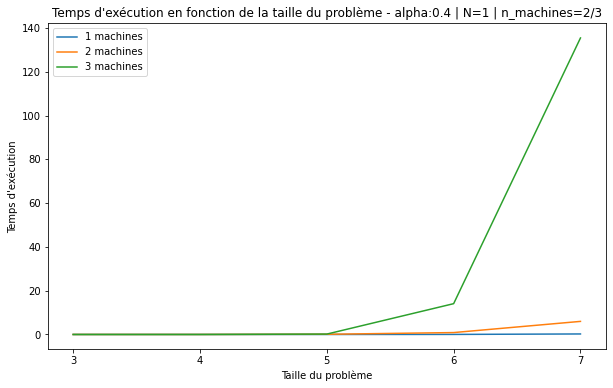

In [26]:
N = 1 #Nombre d'échantillons
n = 8 #Taille maximum du problème
alpha = 0.4

resultats_BB = [[] for i in range(3,n)]
resultats_BB_2 = [[] for i in range(3,n)]
resultats_BB_3 = [[] for i in range(3,n)]

for _ in range(N):
    for i in range(3,n):
        
        p,d,w = genMultiInstances(i,alpha,1)
        #n_machines = 1 
        start = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, True, getPrimal, getDual,exploration_1, 1)
        end = time.time()
        resultats_BB[i-3].append(end-start)
        
        p,d,w = genMultiInstances(i,alpha,2)
        #n_machines = 2 
        start = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, True, getPrimal, getDual,exploration_1, 2)
        end = time.time()
        resultats_BB_2[i-3].append(end-start)
        
        p,d,w = genMultiInstances(i,alpha,3)
        #n_machines = 3
        start = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, True, getPrimal, getDual,exploration_1, 3)
        end = time.time()
        resultats_BB_3[i-3].append(end-start)


resultats_BB_3 = [np.mean(res) for res in resultats_BB_3]
resultats_BB_3 = np.array(resultats_BB_3)

resultats_BB_2 = [np.mean(res) for res in resultats_BB_2]
resultats_BB_2 = np.array(resultats_BB_2)

resultats_BB = [np.mean(res) for res in resultats_BB]
resultats_BB = np.array(resultats_BB)

plt.figure(figsize=(10,6))
X = list(range(3,n))
plt.plot(X,resultats_BB, label="1 machines")
plt.plot(X,resultats_BB_2, label="2 machines")
plt.plot(X,resultats_BB_3, label="3 machines")
plt.xlabel("Taille du problème")
plt.xticks(X)
plt.legend()
plt.ylabel("Temps d'exécution")
plt.title("Temps d'exécution en fonction de la taille du problème - alpha:{} | N={} | n_machines={}".format(alpha,N,"2/3"))
#plt.savefig("img/1-2-3-machines-8.png")